In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm
import logging


from sklearn.model_selection import train_test_split
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

drive.mount('/content/gdrive')


# Create a logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)  # Set the logger to the lowest level to capture all messages

# Create handlers
file_handler = logging.FileHandler('Model_training.log')
console_handler = logging.StreamHandler()

# Set level for handlers
file_handler.setLevel(logging.DEBUG)
console_handler.setLevel(logging.DEBUG)

# Create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
logger.info("Setting the directory path started")
# Set the dataset path
dataset_path = '/content/gdrive/MyDrive/Common fever Causing Viruses/'

# Get the contents of the dataset folder
contents = os.listdir(dataset_path)

# Separate files and directories
files = [f for f in contents if os.path.isfile(os.path.join(dataset_path, f))]
directories = [d for d in contents if os.path.isdir(os.path.join(dataset_path, d))]

# Print the results
print("Files in the dataset folder:")
for file in files:
    print(file)

print("\nDirectories in the dataset folder:")
for directory in directories:
    print(directory)
logger.info("Setting the directory path completed")

2024-07-03 16:28:58,603 - __main__ - INFO - Setting the directory path started
INFO:__main__:Setting the directory path started
2024-07-03 16:28:58,622 - __main__ - INFO - Setting the directory path completed
INFO:__main__:Setting the directory path completed


Files in the dataset folder:

Directories in the dataset folder:
Adeno
Entero
Rhino
Influenza


In [3]:
logger.info("Loading the images and setting the class paths started")
# Define the class paths
class_paths = {
    'Adeno': os.path.join(dataset_path, 'Adeno'),
    'Rhino': os.path.join(dataset_path, 'Rhino'),
    'Entero': os.path.join(dataset_path, 'Entero'),
    'Influenza': os.path.join(dataset_path, 'Influenza')
}

# Create the dataset
X = []
y = []

for virus_name, dir_name in class_paths.items():
    for i in tqdm(os.listdir(dir_name), desc=f"Loading {virus_name} images"):
        try:
            img_path = os.path.join(dir_name, i)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(virus_name)
        except:
            continue

X = np.array(X)
y = np.array(y)

logger.info("Loading the images and setting the class paths completed")

2024-07-03 16:28:58,645 - __main__ - INFO - Loading the images and setting the class paths started
INFO:__main__:Loading the images and setting the class paths started
Loading Influenza images: 100%|██████████| 955/955 [00:33<00:00, 28.75it/s]
2024-07-03 16:31:01,693 - __main__ - INFO - Loading the images and setting the class paths completed
INFO:__main__:Loading the images and setting the class paths completed


In [4]:
logger.info("checking shape of images started")
print(X.shape,y.shape)
logger.info("checking shape of images completed")

2024-07-03 16:31:01,709 - __main__ - INFO - checking shape of images started
INFO:__main__:checking shape of images started
2024-07-03 16:31:01,715 - __main__ - INFO - checking shape of images completed
INFO:__main__:checking shape of images completed


(3878, 150, 150, 3) (3878,)


2024-07-03 16:31:01,731 - __main__ - INFO - Plot 10 random images started
INFO:__main__:Plot 10 random images started


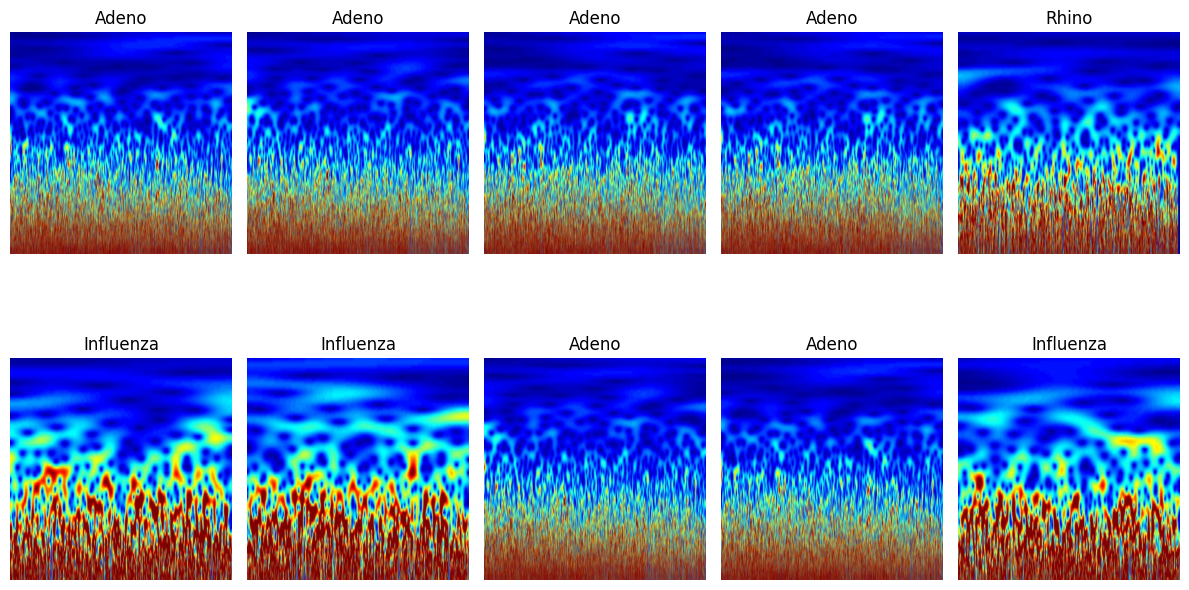

2024-07-03 16:31:04,102 - __main__ - INFO - Plot 10 random images completed
INFO:__main__:Plot 10 random images completed


In [5]:
logger.info("Plot 10 random images started")
fig, axes = plt.subplots(2, 5, figsize=(12, 7))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    # Choose a random class
    virus_name = random.choice(list(class_paths.keys()))
    virus_path = class_paths[virus_name]

    # Choose a random image from the class
    img_files = os.listdir(virus_path)
    img_file = random.choice(img_files)
    img_path = os.path.join(virus_path, img_file)
    img = plt.imread(img_path)

    # Plot the image
    ax.imshow(img)
    ax.set_title(virus_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

logger.info("Plot 10 random images completed")

2024-07-03 16:31:04,128 - __main__ - INFO - Count the number of images in each class started
INFO:__main__:Count the number of images in each class started


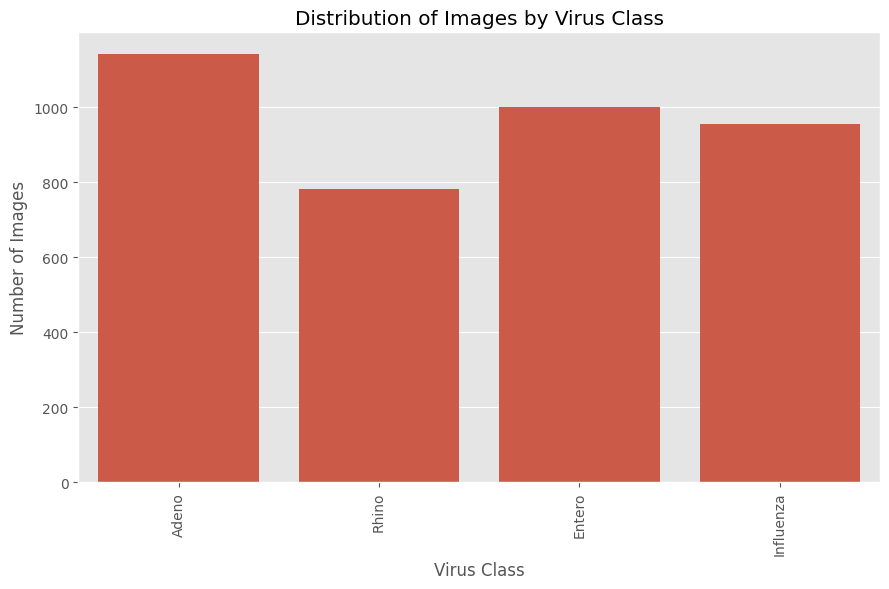

2024-07-03 16:31:04,766 - __main__ - INFO - Count the number of images in each class completed
INFO:__main__:Count the number of images in each class completed


In [6]:

logger.info("Count the number of images in each class started")
class_counts = {virus_name: len(os.listdir(dir_name)) for virus_name, dir_name in class_paths.items()}

# Create the bar plot
plt.figure(figsize=(9, 6))
plt.style.use("ggplot")
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Virus Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images by Virus Class")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

logger.info("Count the number of images in each class completed")

In [7]:
logger.info("Mapping the target attribute started")
# Get the list of unique class names
class_names = list(class_paths.keys())

# Create a mapping dictionary
class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}

# Map the class names to numerical values
y = [class_to_index[class_name] for class_name in y]

print("Mapping dictionary:", class_to_index)
logger.info("Mapped array:", y)
print("conerting it into to_categorical")
y = to_categorical(y)
logger.info("Mapping the target attribute completed")

2024-07-03 16:31:04,780 - __main__ - INFO - Mapping the target attribute started
INFO:__main__:Mapping the target attribute started
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.la

Mapping dictionary: {'Adeno': 0, 'Rhino': 1, 'Entero': 2, 'Influenza': 3}
conerting it into to_categorical


In [8]:
logger.info("Train Test Spliting started")
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)
logger.info("Train Test Spliting completed")

logger.info("Train Validation Spliting started")
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
logger.info("Train Validation Spliting completed")

2024-07-03 16:31:04,892 - __main__ - INFO - Train Test Spliting started
INFO:__main__:Train Test Spliting started
2024-07-03 16:31:05,092 - __main__ - INFO - Train Test Spliting completed
INFO:__main__:Train Test Spliting completed
2024-07-03 16:31:05,097 - __main__ - INFO - Train Validation Spliting started
INFO:__main__:Train Validation Spliting started
2024-07-03 16:31:05,214 - __main__ - INFO - Train Validation Spliting completed
INFO:__main__:Train Validation Spliting completed


In [9]:
def scale_reshape_input(input,target,size):
    """
      Scaling and Reshaping the Imput and Target data

      Args:
          input : Input data for the model
          target : Output data for classification
          size: Size of the reshape image

    """
    #Scaling
    input = np.array(input)/255.0
    # Reshaping
    input = input.reshape(-1,size,size,3)
    target = np.array(target)
    return input,target


In [10]:
def train_eval_val_pred_model(modelname,check):
    """
      Training the model with Train, Test, Validation Set

      Args:
          modelname : Passes the Model names
          check : Setting the Model Check point for Early Stopping

    """

    initial_model = modelname(weights="imagenet", include_top=False, input_shape=(150,150,3))
    # freezing layers
    for l in initial_model.layers:
        l.trainable = False
    # container
    model = Sequential()
    # resnet model
    model.add(initial_model)
    # flattening input to convert it into 1
    model.add(Flatten())

    # classificaion layer
    #model.add(Dropout(0.5))
    #model.add(Dense(512, activation="relu"))
    #model.add(Dropout(0.5))
    #model.add(Dense(256, activation="relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(4,activation = "softmax"))

    # lets see how model looks like
    model.summary()
    # EarlyStopping and Checkpoint
    cp = ModelCheckpoint(check,monitor = "val_accuracy",save_best_only = True,verbose=1)
    es = EarlyStopping(monitor="val_accuracy",patience=8,verbose=1)

    # compile the model
    model.compile(optimizer="adam",loss = "categorical_crossentropy",metrics = ["accuracy"])
    # training
    model_history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val), epochs=25, verbose=1,
                        callbacks = [cp, es])

    # evaluaing the model
    l, acc = model.evaluate(X_test,y_test)
    logger.info(f"Loss for {modelname} during evalution: {l}")
    logger.info(f"Accuracy for{modelname}  during evalution: {acc}")
    l, acc = model.evaluate(X_val,y_val)
    logger.info(f"Loss for {modelname} during Validation: {l}")
    logger.info(f"Accuracy for {modelname} during Validation: {acc}")

    # prediction
    y_pred=model.predict(X_test)

    # retreiving max val from predicted values
    pred = np.argmax(y_pred,axis=1)

    # retreiving max val from actual values
    ground = np.argmax(y_test,axis=1)


    return model_history,ground, pred



In [11]:
def plot_acc_loss(history, epochs,modelname):
    """
      Training the model with Train, Test, Validation Set

      Args:
          history : Model Epoch history with all the evaluation metrics
          epcohs : Count of the epochs model executed
          modelname : Name of model executed

    """

    # Validation and Training accuracy graph
    plt.style.use("ggplot")
    plt.figure(figsize=(12,6))
    epochs = np.arange(1,epochs+1)
    plt.subplot(2,2,1)
    plt.plot(epochs,history.history["accuracy"],"go-")
    plt.plot(epochs,history.history["val_accuracy"],"ro-")
    plt.title(f"Model Accuracy Curve for {modelname}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc = "upper left")

    # Validation and Training loss graph
    plt.subplot(2,2,2)
    plt.plot(epochs,history.history["loss"],"go-")
    plt.plot(epochs,history.history["val_loss"],"ro-")
    plt.title(f"Model Loss Curve for {modelname}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Val"],loc = "upper left")

    plt.show()

In [12]:

def plot_pred_and_actual(X_test, ground, pred, num_rows=5, num_cols=5, figsize=(12, 7)):
    """
    Plots a grid of randomly selected images with their corresponding actual and predicted labels.

    Args:
        X_test : A 4D array of test images in the shape
        ground: A 1D array of actual labels corresponding to the test images.
        pred: A 1D array of predicted labels corresponding to the test images.
        num_rows : The number of rows in the grid. Defaults to 5.
        num_cols : The number of columns in the grid. Defaults to 5.
        figsize : The size of the figure. Defaults to (12, 7).
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flat):
        if i < len(X_test):
            idx = random.randint(0, len(ground) - 1)
            img = X_test[idx]
            actual_label = ground[idx]
            predicted_label = pred[idx]
            ax.imshow(img)
            ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [13]:
logger.info("Scaling and reshaping the input and target variables started")
X_train,y_train = scale_reshape_input(X_train,y_train,150)
X_test,y_test = scale_reshape_input(X_test,y_test,150)
X_val,y_val = scale_reshape_input(X_val,y_val,150)

logger.info("Scaling and reshaping the input and target variables completed")

2024-07-03 16:31:05,285 - __main__ - INFO - Scaling and reshaping the input and target variables started
INFO:__main__:Scaling and reshaping the input and target variables started
2024-07-03 16:31:06,249 - __main__ - INFO - Scaling and reshaping the input and target variables completed
INFO:__main__:Scaling and reshaping the input and target variables completed


In [14]:
logger.info("Traning and Evaluation of ResNet50 Started")
history_ress, ground_ress, pred_ress = train_eval_val_pred_model(ResNet50,'resnet50.h5')
logger.info("Traning and Evaluation of ResNet50 Completed")

logger.info("Traning and Evaluation of VGG19 Started")
history_vgg, ground_vgg, pred_vgg = train_eval_val_pred_model(VGG19,'vgg19.h5')
logger.info("Traning and Evaluation of VGG19 Completed")

2024-07-03 16:31:06,261 - __main__ - INFO - Traning and Evaluation of ResNet50 Started
INFO:__main__:Traning and Evaluation of ResNet50 Started


94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 4)                 204804    
                                                                 
Total params: 23792516 (90.76 MB)
Trainable params: 204804 (800.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/25
39/39 [==============================] - ETA: 0s - loss: 1.1655 - accuracy: 0.6465
Epoch 1: val_accuracy improved from -inf to 0.96618, saving model to resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 19s 278ms/step - loss: 1.1655 - accuracy: 0.6465 - val_loss: 0.4609 - val_accuracy: 0.9662
Epoch 2/25
39/39 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.9613
Epoch 2: val_accuracy improved from 0.96618 to 0.99356, saving model to resnet50.h5
39/39 [==============================] - 5s 138ms/step - loss: 0.3465 - accuracy: 0.9613 - val_loss: 0.2388 - val_accuracy: 0.9936
Epoch 3/25
39/39 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9815
Epoch 3: val_accuracy did not improve from 0.99356
39/39 [==============================] - 5s 130ms/step - loss: 0.2040 - accuracy: 0.9815 - val_loss: 0.1921 - val_accuracy: 0.9517
Epoch 4/25
39/39 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9827
Epoch 4: val_accuracy improved from 0.99356 to 0.99517, saving model to resnet50.h5
39/39 [==============================] - 5s 129ms/step - loss: 0.1519 - accuracy: 0.9827 - val_loss: 0.11

2024-07-03 16:33:44,804 - __main__ - INFO - Loss for <function ResNet50 at 0x7e634deb24d0> during evalution: 0.018803352490067482
INFO:__main__:Loss for <function ResNet50 at 0x7e634deb24d0> during evalution: 0.018803352490067482
2024-07-03 16:33:44,809 - __main__ - INFO - Accuracy for<function ResNet50 at 0x7e634deb24d0>  during evalution: 0.9974226951599121
INFO:__main__:Accuracy for<function ResNet50 at 0x7e634deb24d0>  during evalution: 0.9974226951599121


20/20 [==============================] - 2s 102ms/step - loss: 0.0181 - accuracy: 0.9952


2024-07-03 16:33:47,537 - __main__ - INFO - Loss for <function ResNet50 at 0x7e634deb24d0> during Validation: 0.018089190125465393
INFO:__main__:Loss for <function ResNet50 at 0x7e634deb24d0> during Validation: 0.018089190125465393
2024-07-03 16:33:47,543 - __main__ - INFO - Accuracy for <function ResNet50 at 0x7e634deb24d0> during Validation: 0.9951691031455994
INFO:__main__:Accuracy for <function ResNet50 at 0x7e634deb24d0> during Validation: 0.9951691031455994


25/25 [==============================] - 2s 49ms/step


2024-07-03 16:33:50,445 - __main__ - INFO - Traning and Evaluation of ResNet50 Completed
INFO:__main__:Traning and Evaluation of ResNet50 Completed
2024-07-03 16:33:50,449 - __main__ - INFO - Traning and Evaluation of VGG19 Started
INFO:__main__:Traning and Evaluation of VGG19 Started


80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 20057156 (76.51 MB)
Trainable params: 32772 (128.02 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/25
39/39 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.8932
Epoch 1: val_accuracy improved from -inf to 0.97262, saving model to vgg19.h5
39/39 [============================

2024-07-03 16:38:32,058 - __main__ - INFO - Loss for <function VGG19 at 0x7e634deb3910> during evalution: 0.005150048993527889
INFO:__main__:Loss for <function VGG19 at 0x7e634deb3910> during evalution: 0.005150048993527889
2024-07-03 16:38:32,061 - __main__ - INFO - Accuracy for<function VGG19 at 0x7e634deb3910>  during evalution: 1.0
INFO:__main__:Accuracy for<function VGG19 at 0x7e634deb3910>  during evalution: 1.0


20/20 [==============================] - 4s 187ms/step - loss: 0.0229 - accuracy: 0.9952


2024-07-03 16:38:36,429 - __main__ - INFO - Loss for <function VGG19 at 0x7e634deb3910> during Validation: 0.02288438193500042
INFO:__main__:Loss for <function VGG19 at 0x7e634deb3910> during Validation: 0.02288438193500042
2024-07-03 16:38:36,433 - __main__ - INFO - Accuracy for <function VGG19 at 0x7e634deb3910> during Validation: 0.9951691031455994
INFO:__main__:Accuracy for <function VGG19 at 0x7e634deb3910> during Validation: 0.9951691031455994


25/25 [==============================] - 2s 81ms/step


2024-07-03 16:38:39,251 - __main__ - INFO - Traning and Evaluation of VGG19 Completed
INFO:__main__:Traning and Evaluation of VGG19 Completed


2024-07-03 16:38:39,264 - __main__ - INFO - Plotting Accuracy and Loss Curve for ResNet50 Started
INFO:__main__:Plotting Accuracy and Loss Curve for ResNet50 Started


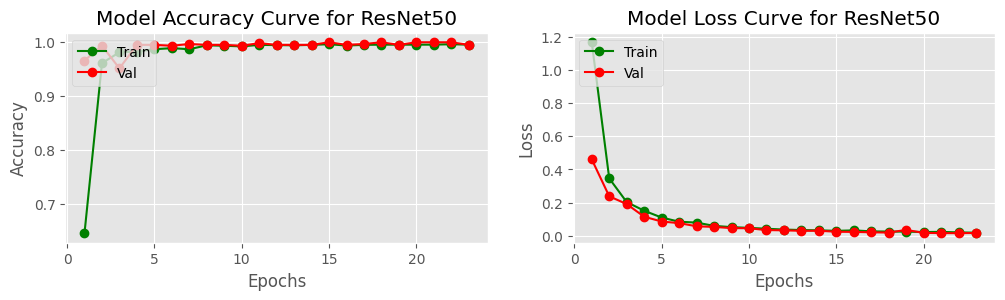

2024-07-03 16:38:39,701 - __main__ - INFO - Plotting Accuracy and Loss Curve for ResNet50 Completed
INFO:__main__:Plotting Accuracy and Loss Curve for ResNet50 Completed
2024-07-03 16:38:39,704 - __main__ - INFO - Plotting Accuracy and Loss Curve for VGG19 Started
INFO:__main__:Plotting Accuracy and Loss Curve for VGG19 Started


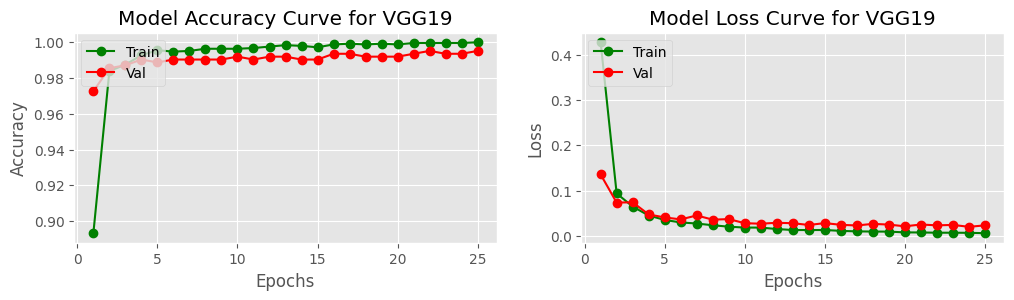

2024-07-03 16:38:40,146 - __main__ - INFO - Plotting Accuracy and Loss Curve for VGG19 Completed
INFO:__main__:Plotting Accuracy and Loss Curve for VGG19 Completed


In [15]:
logger.info("Plotting Accuracy and Loss Curve for ResNet50 Started")
plot_acc_loss(history_ress,len(history_ress.epoch),'ResNet50')
logger.info("Plotting Accuracy and Loss Curve for ResNet50 Completed")

logger.info("Plotting Accuracy and Loss Curve for VGG19 Started")
plot_acc_loss(history_vgg,len(history_vgg.epoch),'VGG19')
logger.info("Plotting Accuracy and Loss Curve for VGG19 Completed")

2024-07-03 16:38:40,162 - __main__ - INFO - Plotting Actual and Predicted for ResNet50 Started
INFO:__main__:Plotting Actual and Predicted for ResNet50 Started


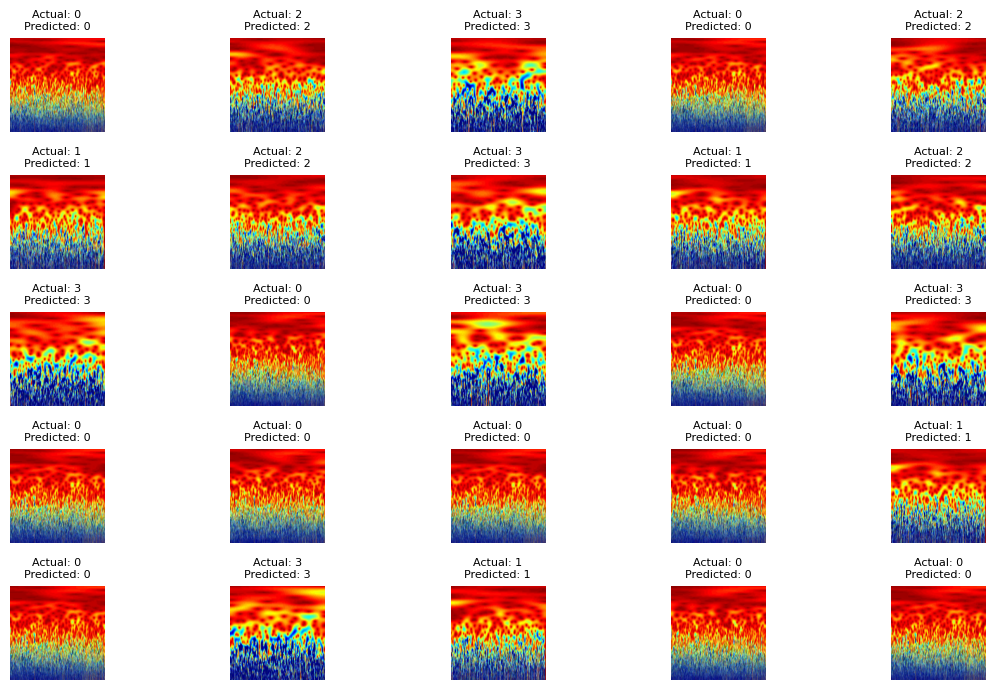

2024-07-03 16:38:41,728 - __main__ - INFO - Plotting Actual and Predicted for ResNet50 Completed
INFO:__main__:Plotting Actual and Predicted for ResNet50 Completed
2024-07-03 16:38:41,733 - __main__ - INFO - Plotting Actual and Predicted for VGG19 Started
INFO:__main__:Plotting Actual and Predicted for VGG19 Started


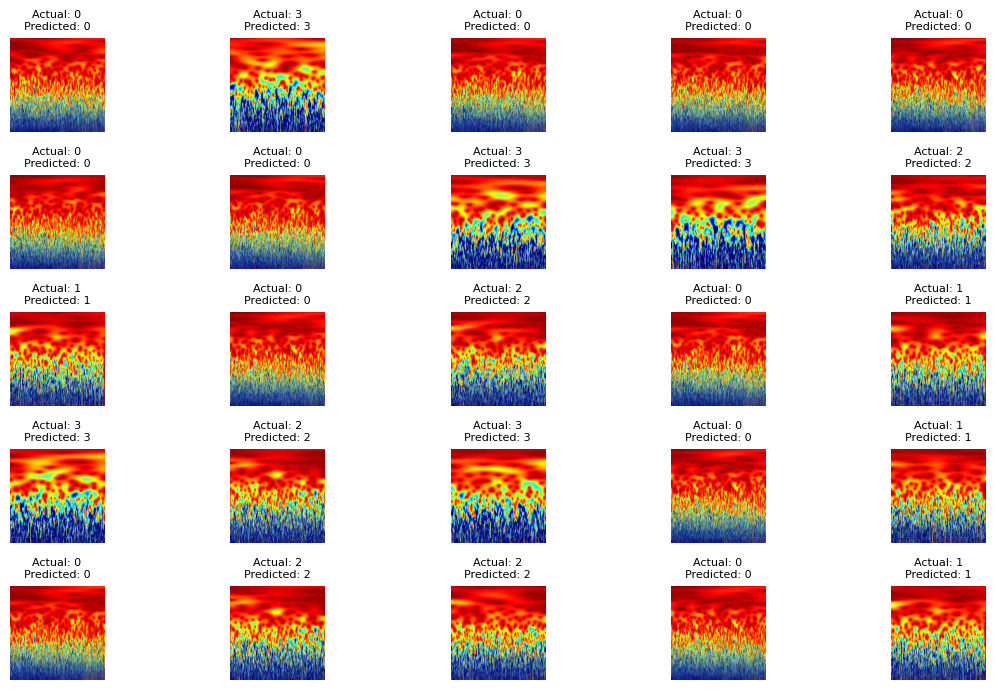

2024-07-03 16:38:43,898 - __main__ - INFO - Plotting Actual and Predicted for VGG19 Completed
INFO:__main__:Plotting Actual and Predicted for VGG19 Completed


In [16]:

logger.info("Plotting Actual and Predicted for ResNet50 Started")
plot_pred_and_actual(X_test, ground_ress, pred_ress)
logger.info("Plotting Actual and Predicted for ResNet50 Completed")

logger.info("Plotting Actual and Predicted for VGG19 Started")
plot_pred_and_actual(X_test, ground_vgg, pred_vgg)
logger.info("Plotting Actual and Predicted for VGG19 Completed")